In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from dataclasses import asdict
from copy import copy

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model
from ATARI.ModelData.particle import Particle, Neutron

import ATARI.syndat.general_functions as gen_funcs
import ATARI.theory.experimental as exp_effects
from ATARI.theory.xs import SLBW

import importlib
%matplotlib widget

The capture cross-section is related to the capture yield (Y) by:

$Y_{\gamma} = \frac{\sigma_{\gamma}}{\sigma_{total}} (1-e^{-n\sigma_{total}}) $



## Data reduction

Data reduction describes calculating the capture yield ($Y$)from a set of experimental measurements.
The following equation describes the relationship between capture yield and measurement data:

$Y_{\gamma} = f_n \frac{\dot{c}_{\gamma} - \dot{c}_{bg}} {\phi} $

For now, let's continue to assume the background function is a constant function at 15 counts and let $f_n = 1$.

The $\phi$ term describes the incident neutron flux on the target and is measured in a separate experiment where the flux shape is determined by measuring detector count rates, subtracting background, and then normalizing by the yield of a well known sample. In many experiments, that well known sample is $B_4C$. The $(n,\alpha\gamma)$ cross section for $B^{10}$ is well characterized and there are no competing photon reactions below 1 MeV. More specifically, the characteristic prompt $\gamma$ at 478 KeV emitted from the $B^{10}(n,\alpha\gamma)$ reaction is measured by a C6D6 detector system. 

The data reduction for this flux measurment is given by:

$\phi = \frac{\dot{c}_{i, B_4C} - \dot{b}_{i, B_4C}} {Y_{i, B_4C}}$

Which leads to the complete data reduction equation:

$Y_{\gamma} = f_n \frac{(\dot{c}_{\gamma} - \dot{c}_{bg}) Y_{i, B_4C}} {\dot{c}_{i, B_4C} - \dot{b}_{i, B_4C}} $

Eventually, we will want to use a real measured count spectrum ($\dot{c}_{i, B_4C}$) from an experiment. 
We will then use MCNP to estimate ${Y_{i, B_4C}}$, or as an intermediate step we can take the normalized cross-section (Aaron's great idea!).
For now, we don't have access to a count spectrum for a $B_4C$ sample. 

But, we do have a different measurement of the flux spectrum ($\phi_i$) from the RPI facility.
This measurement (now included in this folder) is just an open measurement of the flux with a Li6 glass detector.
The ATARI.syndat function approximate_open_spectra() approximates this spectrum with a fitted exponential and can be used to generate realistic flux spectra. 
In this case, however, a $B_4C$ sample was not present. 
So instead on normalizing to ${Y_{i, B_4C}}$, we should normalize to the tritium yield of the Li6 glass detector ${Li^6(n,t)}$ as this is the reaction that causes scintilation and ultimately a signal.

$\phi = \frac{\dot{c}_{i, Li6} - \dot{b}_{i, Li6}} {Y_{i, Li6}}$


<!-- Other variables we may need in the future -->
<!-- | trigo     |      9758727              |   0                         |   -->
<!-- | trigs     |      18476117             |   0                         |   -->
<!-- | t0        |      3.32                 |   0                         |   -->
<!-- | bw        |      0.006                |   0                         |   -->
<!-- | m1        |      1                    |   0.016                     |       -->
<!-- | m2        |      1                    |   0.008                     |       -->
<!-- | m3        |      1                    |   0.018                     |       -->
<!-- | m4        |      1                    |   0.005                     |       -->    
<!-- | ks        |      0.56                 |   0.02402339737495515       |                   -->
<!-- | ko        |      1.47                 |   0.05576763648617445       |                   -->
<!-- | b0s       |      9.                   |   0.1                       |   -->
<!-- | b0o       |      13.                  |   0.7                       |   -->


In [3]:


E_min_max = [5, 2000]
experiment_parameters = {'bw'   :   {'val'  :0.1024,    'unc'  :0},
                         'n'    :   {'val'  :0.067166,  'unc'  :0},
                         't0'   :   {'val'  :3.326,     'unc'  :0},
                         'FP'   :   {'val'  :35.185,    'unc'  :0},
                         'trigo':   {'val'  :9758727,   'unc'  :0}}
experiment_parameters=pd.DataFrame.from_dict(experiment_parameters, orient='index')
tof_min_max     = exp_effects.e_to_t(np.array(E_min_max),experiment_parameters.val.FP, True)*1e6+experiment_parameters.val.t0 #micro s
tof_grid        = np.arange(min(tof_min_max), max(tof_min_max), experiment_parameters.val.bw )#micro s
energy_domain   = exp_effects.t_to_e((tof_grid-experiment_parameters.val.t0)*1e-6,experiment_parameters.val.FP,True) #back to s for conversion to eV


In [4]:
def approximate_open_spectra(energy_grid, smooth_open,experiment_parameters):

        def open_count_rate(tof):
            return (2212.70180199 * np.exp(-3365.55134779 * tof*1e-6) + 23.88486286) 

        tof = exp_effects.e_to_t(energy_grid,experiment_parameters.val.FP,True)*1e6+experiment_parameters.val.t0 # microseconds

        # calculate a tof count rate spectra, convert to counts, add noise 
        cps_open_approx = open_count_rate(tof)
        bin_width = abs(np.append(np.diff(tof), np.diff(tof)[-1])*1e-6)
        cts_open_approx = cps_open_approx*bin_width*experiment_parameters.val.trigo
        if smooth_open:
            cts_open_measured = cts_open_approx
        else:
            cts_open_measured = gen_funcs.pois_noise(cts_open_approx)

        open_dataframe = pd.DataFrame({'tof'    :   tof,
                                        'bw'    :   bin_width,
                                        'c'     :   cts_open_measured,
                                        'dc'    :   np.sqrt(cts_open_measured)})

        open_dataframe['E'] = exp_effects.t_to_e((open_dataframe.tof-experiment_parameters.val.t0)*1e-6, experiment_parameters.val.FP, True) 

        return open_dataframe

Text(0.5, 0, 'E')

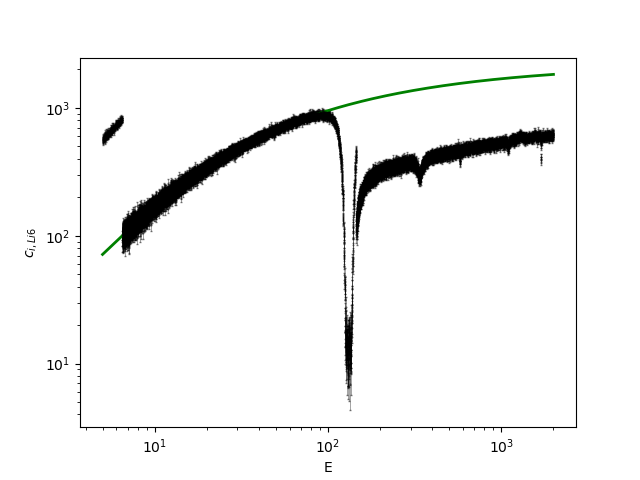

In [5]:
t0 = 3.326
FP = 35.185
trig = 9758727

### function to compare to real open spectrum from RPI
open_data = "./openspec.csv"
measured_odat = pd.read_csv(open_data, sep=',')
measured_odat['E'] = exp_effects.t_to_e((measured_odat.tof-t0)*1e-6, FP, True) 
measured_odat['bw'] = measured_odat.bin_width*1e-6 
measured_odat.rename(columns={"counts": "c", "dcounts": "dc"}, inplace=True)
measured_odat = measured_odat[(measured_odat.E>min(E_min_max)) & (measured_odat.E<max(E_min_max))]

### Fitted open spectrum function from Syndat - smooth_open=True will return a smooth function while False will return a noisy function
fit_odat = approximate_open_spectra(energy_domain, True,experiment_parameters)

plt.figure()
plt.errorbar(measured_odat.E, measured_odat.c, yerr=measured_odat.dc, color='k', fmt='.', ms=1, linewidth=0.5, capsize=0.5, alpha=0.5)
plt.plot(fit_odat.E, fit_odat.c, 'g', lw=2)
plt.yscale('log'); plt.xscale('log')
plt.ylabel(r'$c_{i, Li6}$'); plt.xlabel('E')


### Counts to count rates

Notice that the function above returns counts rather than count rates, this is why there seems to be step changes in the counts observed.
Count rates are calculated by dividing the number of counts in a tof bin by the amount of time that bin was collecting data.
This is given by the following equation where bw is the time-width of bin $i$ and trig is the integer number of times the target saw a burst of neutrons.

$\dot{c_i} = \frac{c_i}{bw_i trig}$

The function ATARI.syndat.exp_effects.cts_to_ctr can be used to do this conversion. 
This function also propagates the uncertainty in counts to count rate.
For the synthetic data generation, you should convert to counts before sampling poisson noise, then convert back to count rates.

Text(0.5, 0, 'E')

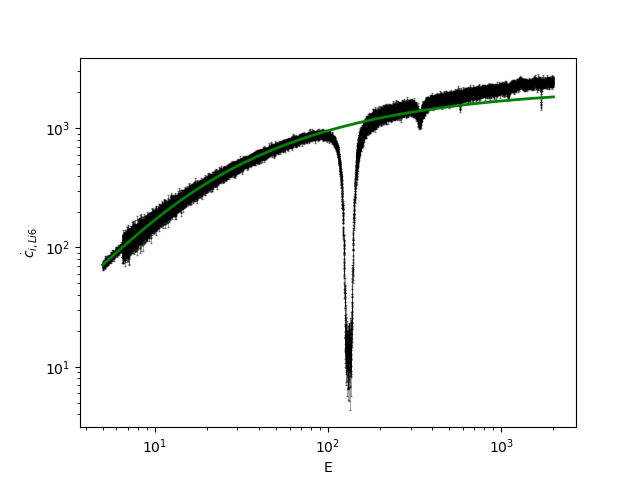

In [6]:
measured_odat["cps"], measured_odat["dcps"] = gen_funcs.cts_to_ctr(measured_odat.c, measured_odat.dc, measured_odat.bw, trig)

fit_odat["cps"], _ = gen_funcs.cts_to_ctr(fit_odat.c, fit_odat.dc, fit_odat.bw, trig)

plt.figure()
plt.errorbar(measured_odat.E, measured_odat.cps, yerr=measured_odat.dcps, color='k', fmt='.', ms=1, 
                                        linewidth=0.5, capsize=0.5, alpha=0.5, zorder=0)
plt.plot(fit_odat.E, fit_odat.cps, 'g', lw=2, zorder=2)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\dot{c}_{i, Li6}$')
plt.xlabel('E')

### Blackout resonance

The feature in the open spectra at around 132 eV is not naturally occuring in the flux spectrum.
In this case, a Co sample was present to 'blackout' the count rate at one point in order to estimate the background.
This energy region is ignored in an actuality, for out synthetic data, we can use the green fitted line as true (ignore the black resonance) and sample around it to get a synthetic 'measurement' of the flux.
The above plots are just to show you waht actual flux data looks like. 

# Generating synthetic data

If the data reduction process is:

$Y_{\gamma} = f_n \frac{(\dot{c}_{\gamma} - \dot{c}_{bg}) Y_{i, Li6}} {\dot{c}_{i, Li6} - \dot{b}_{i, Li6}} $

Then the 'inverse data reduction process' can be used to generate expected observables ($\dot{c}_{\gamma}$) from a true capture yield:

$\dot{c}_{\gamma} = \frac{Y_{\gamma} (\dot{c}_{i, Li6} - \dot{b}_{i, Li6})}{f_n Y_{i, Li6}} + \dot{c}_{bg} $

In order to calculate $\dot{c}_{\gamma}$, all other parameters must be known. 
Other that the capture yield, these parameters will be referred to as reduction parameters. 
For each reduction parameters, we have some estimate of the value and uncertainty that is used for data reduction.
In the inverse reduction (or generation), the estimated value and uncertainty of data reduction parameters are used to sample a set of 'true underlying reduction parameters' or TURPs.
The TURPs are used for the data generation, then the estimated value and uncertainty is used for data reduction.

## Improving what you have so far

1. Read in the Li6 Yield
The csv files Li6_nT and Li6_ntot contain the (n,tritium) and (n,total) cross-sections respectively.
Calculate the expected tritium yield using the yield equation from earlier and take this to be fixed (a neutron data standard).
You will have to linearly interpolate on the provided grid to be on the experimental grid you want to use.

2. Generate $\phi$ for our experiment
Take the yield $Y_{i, Li6}$ as fixed always, sample the count spectrum and background ($\dot{c}_{i, Li6}, \dot{b}_{i, Li6}$) around the true vector. For count spectrum, this can be done using the approximate_open_spectra(exp.energy_domain, smooth_open=False).

3. Plug these into the existing methodology for synthetic data generation
Use the function structure I've outlined below, this will help me integrate your code into Syndat.

4. Also, further verify the uncertainty propagation with monte carlo. 
For a single point in energy, look at a histogram of the standardized error (data-true)/(data_unc). 
This should be distributed as N(0,1)

In [7]:
Ta181 = Particle(Z=73, A=181, I=3.5, mass=180.94803, name='Ta181')
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = [200,250],
                        ac = 0.8127,
                        target=Ta181,
                        projectile=Neutron,
                        l_max = 1
)

# add spin group information for both s-wave resonances
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615, #46.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)


# resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)

resonance_ladder = pd.DataFrame({"E":[31.8030900, 32.3453560, 43.3031830, 56.0645210, 63.9661590],
                                 "Gg":[54.9451300, 59.0939900, 59.7455500, 86.1347900, 67.1257900],
                                 "Gn":[0.3913400,0.0582700,2.9012500,2.1717400,0.0021400],
                                 "J":[3,3,3,3,3], "chs":[1,1,1,1,1], "lwave":[0,0,0,0,0], "J_ID":[1,1,1,1,1]})

xs_tot, xs_scat, xs_cap = SLBW(energy_domain, Ta_pair, resonance_ladder)
capture_df = pd.DataFrame({"E":energy_domain, "theo_xs":xs_cap})
total_df = pd.DataFrame({"E":energy_domain, "theo_xs":xs_tot})

In [8]:
def Sample_Poisson_Distribution(Dis):
    """Generates a poisson distribution around a given theoretical distribution.
    
    Arguments:
        Theo_Dis        -- (n) array of floats:     The theoretical distribution to be sampled around

    Returns:
        Sampled_Dis     -- (2,n) array of floats: The noisy sampled distribtuion around the theoreical and the associated uncertainties
        
        !Note: The first index is the sampled distribution, the second index is the associated uncertainty
    """
    #Sample Calculations:
    sample_data = {"Distribution":np.random.poisson(Dis["Distribution"])}
    
    #Uncertainty Calculations:
    sample_data["Uncertainty"] = np.sqrt(sample_data["Distribution"])
    
    return(sample_data)

def Sample_Gaussian_Distribution(Dis):
    """Generates a poisson distribution around a given theoretical distribution.
    
    Arguments:
        Theo_Dis        -- (n) array of floats:     The theoretical distribution to be sampled around

    Returns:
        Sampled_Dis     -- (2,n) array of floats: The noisy sampled distribtuion around the theoreical and the associated uncertainties
        
        !Note: The first index is the sampled distribution, the second index is the associated uncertainty
    """
    if ("Jacobian" in Dis.keys()):
        sample_data = {"Distribution":np.random.normal(Dis["Distribution"],np.diag(Dis["Jacobian"]))}
        sample_data["Jacobian"] = Dis["Jacobian"]
        
    elif("Uncertainty" in Dis.keys()):
        sample_data = {"Distribution":np.random.normal(Dis["Distribution"],Dis["Uncertainty"])}
        sample_data["Uncertainty"] = Dis["Uncertainty"]
        
    else:
        sample_data = {"Distribution":Dis["Distribution"]}
        
    return(sample_data)

In [9]:
def Propogate_Uncertainty(variables,derivatives,domain_length):
    key_list=set().union(*(d.keys() for d in variables))
    
    if("Jacobian" in key_list):
        derivative_matrices=[]
        covariance_matrices=[]
        
        for idx,variable in enumerate(variables):
            if(("Jacobian" in variable.keys())or("Uncertainty" in variable.keys())):
                derivative_matrices.append(np.diag(derivatives[idx]))
                if("Jacobian" in variable.keys()):
                    covariance_matrices.append(variable["Jacobian"])
                else:
                    covariance_matrices.append(np.diag(np.power(variable["Uncertainty"],2)))
        derivative_matrix=np.concatenate(derivative_matrices,1)
        
        covariance_template=np.eye(len(covariance_matrices))
        row_stacks=[]
        for r in range(len(covariance_matrices)):
            row_matrices=[]
            for c in range(len(covariance_matrices)):
                row_matrices.append(covariance_matrices[c]*covariance_template[r,c])
            row_stacks.append(np.concatenate(row_matrices,1))
        covariance_matrix=np.concatenate(row_stacks,0)
        
        return({"Jacobian":derivative_matrix@covariance_matrix@(derivative_matrix.T)})
    
    elif("Uncertainty" in key_list):
        running_uncertainty=np.zeros(domain_length)
        for idx,variable in enumerate(variables):
            if("Uncertainty" in variable.keys()):
                running_uncertainty=running_uncertainty+(np.power(derivatives[idx],2)*np.power(variable["Uncertainty"],2))
        
        return({"Uncertainty":np.sqrt(running_uncertainty)})
    
    return({})

In [10]:
#A handful of quick, simple unit tests to make sure the error_propogation is giving us what we want in the general case

a={"Distribution":np.array([1,2,3]),
   "Uncertainty":np.array([0.5,0.5,0.5])}
b={"Distribution":np.array([2,4,6]),
   "Uncertainty":np.array([1,1,1])}
a_der=np.ones(3)
b_der=np.ones(3)

d={"Distribution":a["Distribution"]+b["Distribution"]}
print(d["Distribution"])

print(Propogate_Uncertainty([a,b],[a_der,b_der],3))

a={"Distribution":np.array([1,2,3]),
   "Uncertainty":np.array([0.5,0.5,0.5])}
b={"Distribution":np.array([2,4,6]),
   "Jacobian":np.diag(np.array([1,1,1]))}
c=10

d={"Distribution":a["Distribution"]+b["Distribution"]+c}
print(d["Distribution"])

print(Propogate_Uncertainty([a,b],[a_der,b_der],3))

a={"Distribution":np.array([1,2,3]),
   "Jacobian":np.diag(np.array([0.5,0.5,0.5]))}
b={"Distribution":np.array([2,4,6]),
   "Jacobian":np.diag(np.array([1,1,1]))}
c=10

d={"Distribution":a["Distribution"]+b["Distribution"]+c}
print(d["Distribution"])

print(Propogate_Uncertainty([a,b],[a_der,b_der],3))

[3 6 9]
{'Uncertainty': array([1.11803399, 1.11803399, 1.11803399])}
[13 16 19]
{'Jacobian': array([[1.25, 0.  , 0.  ],
       [0.  , 1.25, 0.  ],
       [0.  , 0.  , 1.25]])}
[13 16 19]
{'Jacobian': array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])}


In [11]:
def XS_to_Yield(reaction_xs, total_xs, target_per_barn):
    """Calculates the theoretical yield and count rate distributions

    Arguments:
        capture_xs_theo -- (n) array of floats: The theoretical capture cros-section distribution for Energy
        total_xs_theo   -- (n) array of floats: The theoretical total cross-section distribution for Energy
        target_per_barn -- float:               The number of target atoms per unit length

    Returns:
        yield_theo      -- (n) array of floats: The theoretical capture yield distribtuion for Energy
    """
    #Distribution
    Yield               = {"Distribution":np.multiply(np.divide(reaction_xs["Distribution"],total_xs["Distribution"]), (1-np.exp(np.multiply(-target_per_barn,total_xs["Distribution"]))))}
    
    #Derivatives
    reaction_derivative = np.multiply(np.divide(1,total_xs["Distribution"]), (1-np.exp(np.multiply(-target_per_barn,total_xs["Distribution"]))))
    total_derivative    = np.multiply(reaction_xs["Distribution"],(np.divide(np.exp(np.multiply(-target_per_barn,total_xs["Distribution"])),np.power(total_xs["Distribution"],2))+np.divide(target_per_barn*np.exp(np.multiply(-target_per_barn,total_xs["Distribution"])),total_xs["Distribution"])-np.divide(1,np.power(total_xs["Distribution"],2))))
    
    #Error Propogation
    Yield.update(Propogate_Uncertainty([reaction_xs,total_xs], [reaction_derivative,total_derivative], len(reaction_xs["Distribution"])))
    
    return(Yield)

def Yield_to_Flux(Yield,countrate,background):
    """__Summary__
    
    Arugments:
        __Name__ -- __Type__: __Description__
    
    Modes:
        __Name__ -- __Type__: __Value 1__=__Mode Option 1__
                              __Value 2__=__Mode Option 2__
    
    Returns:
        __Name__ -- __Type__: __Description__
    """
    #Distribution
    flux                = {"Distribution":np.divide(countrate["Distribution"] - background["Distribution"], Yield["Distribution"])}
    
    #Derivatives
    yield_derivative    =-np.divide(countrate["Distribution"] - background["Distribution"], np.power(Yield["Distribution"],2))
    Cc_derivative       = np.divide(1, Yield["Distribution"])
    Cb_derivative       =-np.divide(1, Yield["Distribution"])
    
    #Error Propogation
    flux.update(Propogate_Uncertainty([Yield,countrate,background], [yield_derivative,Cc_derivative,Cb_derivative], len(Yield["Distribution"])))
    
    return(flux)

def inverse_reduction(exp_yield, exp_background, exp_scaling, test_flux):
    """_summary_

    Args:
        true_capture_yield (_type_): _description_
        true_reduction_parameters (_type_): _description_
    """
    #Distribution
    countrate           = {"Distribution":np.divide(np.multiply(exp_yield["Distribution"],test_flux["Distribution"]),exp_scaling["Distribution"]) + exp_background["Distribution"]}
    
    #Derivatives
    yield_derivative    = np.divide(test_flux["Distribution"],  exp_scaling["Distribution"])
    Cb_derivative       = np.ones(len(exp_yield["Distribution"]))
    scaling_derivative  = np.divide(np.multiply(test_flux["Distribution"], exp_yield["Distribution"]), np.power(exp_scaling["Distribution"],2))
    flux_derivative     = np.divide(exp_yield["Distribution"], exp_scaling["Distribution"])
    
    #Error Propogation
    countrate.update(Propogate_Uncertainty([exp_yield,exp_background,exp_scaling,test_flux], [yield_derivative,Cb_derivative,scaling_derivative,flux_derivative], len(exp_yield["Distribution"])))
    
    return(countrate)

def reduce(exp_background, exp_scaling, exp_countrate,test_flux):
    """Calculates sample yield and it's uncertainty.
    
    Arguments:
        count_exp       -- (2,n,m) array of floats: The experimental capture count rate distribution for Energy and it's uncertainty
        background_exp  -- (2,n,m) array of floats: The experimental background count rate distribtuion for Energy and it's uncertainty
        flux_exp        -- (2,n,m) array of floats: The experimental neutron flux distribtuion for Energy and it's uncertainty

    Returns:
        yield_exp       -- (2,n,m) array of floats: The experimental yield distribution for Energy and it's uncertainty
        
        !Note: The first index for each value is the experimental distribution, the second index is the associated uncertainty
    """
    #Distribution
    Yield               = {"Distribution":np.multiply(exp_scaling["Distribution"], np.divide(exp_countrate["Distribution"] - exp_background["Distribution"], test_flux["Distribution"]))}
    
    #Derivatives
    Cb_derivative       =-np.divide(exp_scaling["Distribution"], test_flux["Distribution"])
    scaling_derivative  = np.divide(exp_countrate["Distribution"] - exp_background["Distribution"], test_flux["Distribution"])
    Cc_derivative       = np.divide(exp_scaling["Distribution"], test_flux["Distribution"])
    flux_derivative     =-np.multiply(exp_scaling["Distribution"], np.divide(exp_countrate["Distribution"] - exp_background["Distribution"], np.power(test_flux["Distribution"],2)))
    
    #Error Propogation
    Yield.update(Propogate_Uncertainty([exp_background,exp_scaling,exp_countrate,test_flux], [Cb_derivative,scaling_derivative,Cc_derivative,flux_derivative], len(exp_background["Distribution"])))
    
    return(Yield)

def sample_true_underlying_reduction_parameters(energy_domain, test_background, exp_background, exp_scaling, 
                                                testCbSampType, expCbSampType):
    """_summary_

    Args:
        exp (_type_): _description_
        test_background_theo (_type_): _description_
        exp_background_theo (_type_): _description_
    """
    test_background = Sample_Poisson_Distribution(test_background) if testCbSampType=="Poisson"   else Sample_Gaussian_Distribution(test_background)
    exp_background  = Sample_Poisson_Distribution(exp_background)  if expCbSampType=="Poisson"    else Sample_Gaussian_Distribution(exp_background)
    exp_scaling     = Sample_Gaussian_Distribution(exp_scaling)
    
    test_counts     = approximate_open_spectra(energy_domain, False, experiment_parameters)
    test_countrate  ={}
    test_countrate["Distribution"], test_countrate["Uncertainty"] = gen_funcs.cts_to_ctr(test_counts.c, test_counts.dc, test_counts.bw, trig)
    
    return(exp_background, exp_scaling, test_background, test_countrate)

def generate(energy_domain, exp_yield, exp_background, exp_scaling, test_yield, test_countrate, test_background,
             sampleTURPS=True, sampleNoise=True, testSampType="Poisson", expSampType="Poisson", FluxSampleType="Propogated"):
    """_summary_

    Args:
        exp_yield_theo (_type_): _description_
        exp_background (_type_): _description_
        test_yield (_type_): _description_
        test_countrate (_type_): _description_
        test_background (_type_): _description_
        exp_scaling (_type_): _description_
        sampleTURPS (_type_): _description_
        option_to_sample_noise (_type_): _description_
    """
    #Sampling
    if(sampleTURPS):
        exp_background, exp_scaling, test_background, test_countrate = sample_true_underlying_reduction_parameters(energy_domain, test_background, exp_background, exp_scaling,
                                                                                                                   testSampType, expSampType)
        
    #Test Flux Calcs
    if(FluxSampleType  =="Propogated"):
        test_flux      = Yield_to_Flux(test_yield, test_countrate, test_background)
    elif(FluxSampleType=="Poisson"):
        test_flux      = Sample_Poisson_Distribution({"Distribution":np.ones(len(energy_domain))*10000,"Uncertainty":np.ones(len(energy_domain))*10})
    elif(FluxSampleType=="Gaussian"):
        test_flux      = Sample_Gaussian_Distribution({"Distribution":np.ones(len(energy_domain))*10000,"Uncertainty":np.ones(len(energy_domain))*10})
    else:
        test_flux     = {"Distribution":np.ones(len(energy_domain))*10000,"Uncertainty":np.ones(len(energy_domain))*10}
    
    #Experiment Countrate Calcs
    exp_countrate     = inverse_reduction(exp_yield, exp_background, exp_scaling, test_flux)
    
    #Countrate Sampling
    if(sampleNoise):
        exp_countrate = Sample_Gaussian_Distribution(exp_countrate)
    
    return(exp_countrate,test_background, test_countrate, exp_background,exp_scaling,test_flux)

In [12]:
def GenerationWrapper(exp_yield_theo, exp_background_theo, exp_scaling_theo, test_yield_theo, test_countrate_theo, test_background_theo):
    exp_countrate_samp,test_background_samp,test_countrate_samp,exp_background_samp,exp_scaling_samp,test_flux  =generate           (energy_domain, exp_yield_theo, exp_background_theo, exp_scaling_theo, test_yield_theo, test_countrate_theo, test_background_theo,
                                                                                                                                     sampleTURPS=False, sampleNoise=False, testSampType="Poisson", expSampType="Gaussian", FluxSampleType="Propogated")
    exp_countrate_theo                                                                                          =inverse_reduction  (exp_yield_theo, exp_background_samp, exp_scaling_samp, test_flux)
    exp_countrate_samp                                                                                          =exp_countrate_theo
    exp_yield_samp                                                                                              =reduce             (exp_background_samp, exp_scaling_samp, exp_countrate_samp,test_flux)
    
    return(exp_countrate_samp,test_background_samp,test_countrate_samp,exp_background_samp,test_flux,exp_scaling_samp,exp_countrate_theo,exp_yield_samp)

In [13]:
#Constants

#Values for flux test experiment
test_target_per_barn=0.06                                                   #Number of target atoms per unit length

test_background_theo =  {"Distribution" : np.ones(len(energy_domain))*25}   #Theoretical background count rate distribution

trig =                  9758727                                             #Number of neutron bursts in test

#Values for actual experiment
exp_target_per_barn =   0.06                                                #Number of target atoms per unit length

exp_background_theo =   {"Distribution" : np.ones(len(energy_domain))*25,
                         "Uncertainty"  : np.ones(len(energy_domain))*5}    #Theoretical background count rate distribution

exp_scaling_theo =      {"Distribution" : np.ones(len(energy_domain))*1}    #Scaling function





#gets the test cross sections from csv files
Li6_xs_total=pd.read_csv("Li6_ntot.csv",skiprows=26,skipfooter=5,names=["E","theo_xs","interp"],delim_whitespace=True,engine='python')
Li6_xs_tritium=pd.read_csv("Li6_nT.csv",skiprows=26,skipfooter=5,names=["E","theo_xs","interp"],delim_whitespace=True,engine='python')


#get everything on the same energy space
test_xs_total={"Distribution":np.interp(energy_domain,Li6_xs_total.E,Li6_xs_total.theo_xs)}
test_xs_total["Uncertainty"]=np.sqrt(test_xs_total["Distribution"]*0.05)
# test_xs_total["Jacobian"]=np.diag(test_xs_total["Distribution"])*0.05
# test_xs_total["Jacobian"]=np.ones((len(energy_domain),len(energy_domain)))*0.05
# np.fill_diagonal(test_xs_total["Jacobian"],test_xs_total["Distribution"]*0.5)

test_xs_react={"Distribution":np.interp(energy_domain,Li6_xs_tritium.E,Li6_xs_tritium.theo_xs)}
test_xs_react["Uncertainty"]=np.sqrt(test_xs_react["Distribution"]*0.05)
# test_xs_react["Jacobian"]=np.diag(test_xs_react["Distribution"])*0.05
# test_xs_react["Jacobian"]=np.ones((len(energy_domain),len(energy_domain)))*0.05
# np.fill_diagonal(test_xs_react["Jacobian"],test_xs_react["Distribution"]*0.5)


#finds the theoretical test yield
test_yield_theo=XS_to_Yield(test_xs_total, test_xs_react, test_target_per_barn)


#Approximates a theoretical test countrate
test_count_theo = approximate_open_spectra(energy_domain, False, experiment_parameters)
test_countrate_theo={}
test_countrate_theo["Distribution"],test_countrate_theo["Uncertainty"] = gen_funcs.cts_to_ctr(test_count_theo.c, test_count_theo.dc, test_count_theo.bw, trig)


#finds the theoretical experiment yield
exp_yield_theo=XS_to_Yield({"Distribution":capture_df.theo_xs},{"Distribution":total_df.theo_xs},exp_target_per_barn)


exp_countrate_samp,test_background_samp,test_countrate_samp,exp_background_samp,test_flux,exp_scaling_samp,exp_countrate_theo,exp_yield_samp=GenerationWrapper(exp_yield_theo, exp_background_theo, exp_scaling_theo, test_yield_theo, test_countrate_theo, test_background_theo)
test_flux_theo=Yield_to_Flux(test_yield_theo, test_countrate_theo, test_background_theo)
exp_countrate_theo_2=inverse_reduction(exp_yield_theo, exp_background_theo, exp_scaling_theo, test_flux_theo)

In [14]:
#get everything on the same energy space
j_test_xs_total={"Distribution":np.interp(energy_domain,Li6_xs_total.E,Li6_xs_total.theo_xs)}
#j_test_xs_total["Uncertainty"]=np.sqrt(j_test_xs_total["Distribution"]*0.05)
j_test_xs_total["Jacobian"]=np.diag(j_test_xs_total["Distribution"])*0.05
# j_test_xs_total["Jacobian"]=np.ones((len(energy_domain),len(energy_domain)))*0.05
# np.fill_diagonal(j_test_xs_total["Jacobian"],j_test_xs_total["Distribution"]*0.5)

j_test_xs_react={"Distribution":np.interp(energy_domain,Li6_xs_tritium.E,Li6_xs_tritium.theo_xs)}
#j_test_xs_react["Uncertainty"]=np.sqrt(j_test_xs_react["Distribution"]*0.05)
j_test_xs_react["Jacobian"]=np.diag(j_test_xs_react["Distribution"])*0.05
# j_test_xs_react["Jacobian"]=np.ones((len(energy_domain),len(energy_domain)))*0.05
# np.fill_diagonal(j_test_xs_react["Jacobian"],j_test_xs_react["Distribution"]*0.05)


#finds the theoretical test yield
j_test_yield_theo=XS_to_Yield(j_test_xs_total, j_test_xs_react, test_target_per_barn)

j_exp_countrate_samp,j_test_background_samp,j_test_countrate_samp,j_exp_background_samp,j_exp_scaling_samp,j_test_flux  =generate           (energy_domain, exp_yield_theo, exp_background_theo, exp_scaling_theo, j_test_yield_theo, test_countrate_theo, test_background_theo,
                                                                                                                                             sampleTURPS=False, sampleNoise=False, testSampType="Poisson", expSampType="Gaussian", FluxSampleType="Propogated")
#exp_countrate_theo                                                                                                      =inverse_reduction  (exp_yield_theo, exp_background_samp, exp_scaling_samp, test_flux)
#exp_countrate_samp                                                                                                      =exp_countrate_theo
#exp_yield_samp                                                                                                          =reduce             (exp_background_samp, exp_scaling_samp, exp_countrate_samp,test_flux)
#j_test_flux_theo=Yield_to_Flux(j_test_yield_theo, test_countrate_theo, test_background_theo)


In [16]:
print(np.max(test_flux["Uncertainty"]-np.sqrt(np.diag(j_test_flux["Jacobian"]))))
print(np.max(exp_countrate_samp["Uncertainty"]-np.sqrt(np.diag(j_exp_countrate_samp["Jacobian"]))))

2.2737367544323206e-13


KeyError: 'Jacobian'

In [25]:
%matplotlib
from ipywidgets import *


def plotter(things_to_plot):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    def update(plot, x_log, y_log):
        item=things_to_plot[plot]
        ax.clear()
        
        ax.set_title(item["Title"])
        
        if(x_log):
            ax.set_xscale("log")
        else:
            ax.set_xscale("linear")
        
        if(y_log):
            ax.set_yscale("log")
        else:
            ax.set_yscale("linear")
        
        for i in range(len(item["Distributions"])):
            if(item["Plot Types"][i]==0):
                if("Uncertainty" in item["Distributions"][i].keys()):
                    ax.errorbar(item["Domain"], item["Distributions"][i]["Distribution"],yerr=item["Distributions"][i]["Uncertainty"],ecolor=item["Error Colors"][i],fmt=".",color=item["Colors"][i],linewidth=0.25,markersize=1.5,capsize=1,zorder=item["Z Order"][i],label=item["Labels"][i])
                elif("Jacobian" in item["Distributions"][i].keys()):
                    ax.errorbar(item["Domain"], item["Distributions"][i]["Distribution"],yerr=np.sqrt(np.diag(item["Distributions"][i]["Jacobian"])),ecolor=item["Error Colors"][i],fmt=".",color=item["Colors"][i],linewidth=0.25,markersize=1.5,capsize=1,zorder=item["Z Order"][i],label=item["Labels"][i])
                else:
                    ax.scatter(item["Domain"],item["Distributions"][i]["Distribution"],c=item["Colors"][i],zorder=item[7][i],marker=".",s=1.5,label=item["Labels"][i])
            elif(item["Plot Types"][i]==1):
                ax.plot(item["Domain"], item["Distributions"][i]["Distribution"],c=item["Colors"][i],zorder=item["Z Order"][i],label=item["Labels"][i])
            else:
                ax.plot(item["Domain"], item["Distributions"][i]["Distribution"],c=item["Colors"][i],zorder=item["Z Order"][i],label=item["Labels"][i])
                
        ax.legend()
        fig.canvas.draw()

    interact(update, plot=widgets.IntSlider(min=0, max=(len(things_to_plot)-1), step=1, value=0), x_log=True, y_log=True);

Using matplotlib backend: module://ipympl.backend_nbagg


interactive(children=(IntSlider(value=0, description='plot', max=3), Checkbox(value=True, description='x_log')…

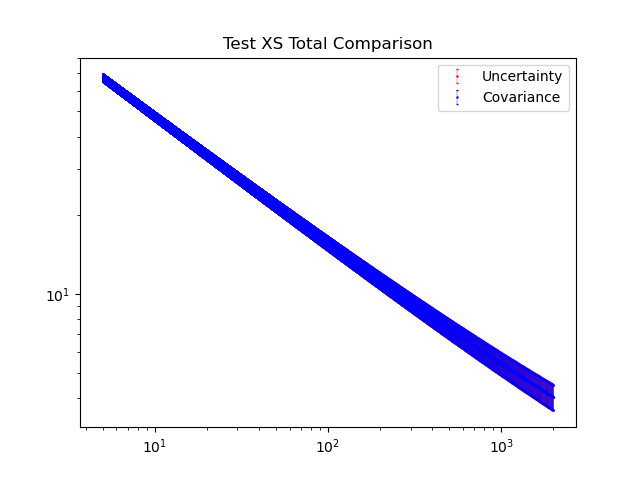

In [36]:
things_to_plot=[{"Title":"Test XS Total Comparison",
                 "Domain":energy_domain,
                 "Labels":["Uncertainty","Covariance"],
                 "Distributions":[test_xs_total,j_test_xs_total],
                 "Colors":["r","b"],
                 "Error Colors":["r","b"],
                 "Plot Types":[0,0],
                 "Z Order":[0,1]},
                {"Title":"Test XS Reaction Comparison",
                 "Domain":energy_domain,
                 "Labels":["Uncertainty","Covariance"],
                 "Distributions":[test_xs_react,j_test_xs_react],
                 "Colors":["r","b"],
                 "Error Colors":["r","b"],
                 "Plot Types":[0,0],
                 "Z Order":[0,1]},
                {"Title":"Test Yield Comparison",
                 "Domain":energy_domain,
                 "Labels":["Uncertainty Yield","Covariance Yield"],
                 "Distributions":[test_yield_theo,j_test_yield_theo],
                 "Colors":["r","b"],
                 "Error Colors":["r","b"],
                 "Plot Types":[0,0],
                 "Z Order":[0,1]},
                {"Title":"Flux Comparison",
                 "Domain":energy_domain,
                 "Labels":["Uncertainty Flux","Covariance Flux"],
                 "Distributions":[test_flux,j_test_flux],
                 "Colors":["r","b"],
                 "Error Colors":["r","b"],
                 "Plot Types":[0,0],
                 "Z Order":[0,1]}
                ]
plotter(things_to_plot)

interactive(children=(IntSlider(value=0, description='plot', max=6), Checkbox(value=True, description='x_log')…

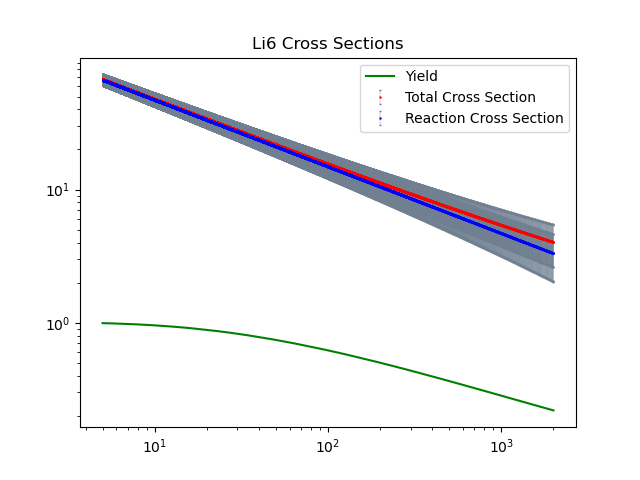

In [88]:
#Plotting
things_to_plot=[{"Title":"Li6 Cross Sections",
                 "Domain":energy_domain,
                 "Labels":["Total Cross Section","Reaction Cross Section","Yield"],
                 "Distributions":[test_xs_total,test_xs_react,test_yield_theo],
                 "Colors":["r","b","g"],
                 "Plot Types":[0,0,1],
                 "Z Order":[0,0,0]},
                {"Title":"Li6 Background Countrate",
                 "Domain":energy_domain,
                 "Labels":["Background Sampled","Countrate Sampled","Background Theoretical","Countrate Theoretical"],
                 "Distributions":[test_background_samp,test_countrate_samp,test_background_theo,test_countrate_theo],
                 "Colors":["k","k","y","orange"],
                 "Plot Types":[0,0,1,1],
                 "Z Order":[0,0,1,1]},
                {"Title":"Experiment Flux",
                 "Domain":energy_domain,
                 "Labels":["Flux", "Flux Theoretical"],
                 "Distributions":[test_flux,test_flux_theo],
                 "Colors":["k","cyan"],
                 "Plot Types":[0,1],
                 "Z Order":[1,0]},
                {"Title":"Experiment Yield Theoretical",
                 "Domain":energy_domain,
                 "Labels":["Yield Sampled","Yield Theoretical"],
                 "Distributions":[exp_yield_samp,exp_yield_theo],
                 "Colors":["k","y"],
                 "Plot Types":[0,1],
                 "Z Order":[0,1]},
                {"Title":"Experiment Count rate",
                 "Domain":energy_domain,
                 "Labels":["Countrate Sampled","Countrate Theoretical (Method 1)","Countrate Theoretical (Method 2)"],
                 "Distributions":[exp_countrate_samp,exp_countrate_theo,exp_countrate_theo_2],
                 "Colors":["k","b","purple"],
                 "Plot Types":[0,1,1],
                 "Z Order":[3,1,2]},
                {"Title":"Experiment background rate",
                 "Domain":energy_domain,
                 "Labels":["Background Sampled","Background Theoretical"],
                 "Distributions":[exp_background_samp,exp_background_theo],
                 "Colors":["k","g"],
                 "Plot Types":[0,1],
                 "Z Order":[0,1]},
                {"Title":"Experiment Scaling",
                 "Domain":energy_domain,
                 "Labels":["Scaling Sampled","Scaling Theoretical"],
                 "Distributions":[exp_scaling_samp,exp_scaling_theo],
                 "Colors":["k","pink"],
                 "Plot Types":[0,1],
                 "Z Order":[0,1]}]
plotter(things_to_plot)

In [ ]:
num_runs=1000
num_of_graphs=5

collection=np.empty((num_of_graphs,2,len(energy_domain),num_runs))

for run in range(num_runs):
    exp_countrate_samp,test_background_samp,test_countrate_samp,exp_background_samp,test_flux,exp_scaling_samp,exp_countrate_theo,exp_yield_samp=GenerationWrapper(exp_yield_theo, exp_background_theo, exp_scaling_theo, test_yield_theo, test_countrate_theo, test_background_theo)
    collection[0,:,:,run]=exp_yield_samp
    collection[1,:,:,run]=exp_countrate_samp
    collection[2,:,:,run]=test_flux
    collection[3,:,:,run]=exp_background_samp
    collection[4,:,:,run]=exp_scaling_samp

collection_mean =np.mean(collection,3)
collection_upper=np.quantile(collection,0.841,3)
collection_lower=np.quantile(collection,0.159,3)
collection_min  =np.min(collection,3)
collection_max  =np.max(collection,3)

0

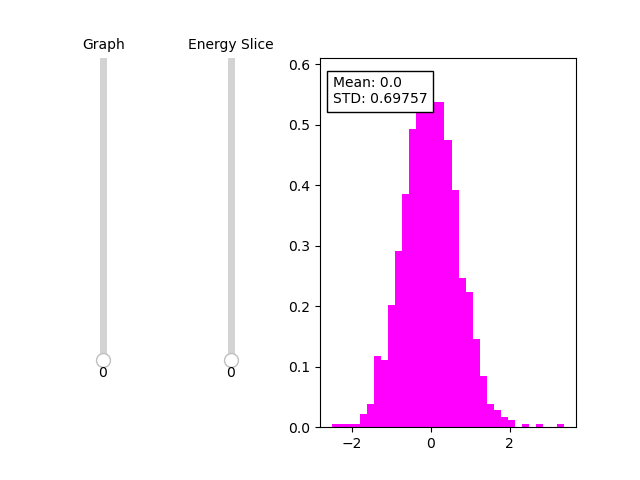

In [ ]:
energy_slice=0
Graph_to_Show=0

def updatePlot():
    ax.cla()
    y_bar_y_hat=collection[Graph_to_Show,0]-np.tile(collection_mean[Graph_to_Show,0],(num_runs,1)).T
    Yield_hist=y_bar_y_hat/np.tile(collection_mean[Graph_to_Show,1],(num_runs,1)).T
    
    Yield_hist_mean=np.mean(Yield_hist,1)
    Yield_hist_std=np.std(Yield_hist,1)
    
    ax.hist(Yield_hist[energy_slice], bins='auto',color="magenta",density=True)
    text=ax.text(0.05, 0.95, ("Mean: "+str(round(Yield_hist_mean[energy_slice],5)+0)+"\n"+"STD: "+str(round(Yield_hist_std[energy_slice],5)+0)),
                    horizontalalignment='left',
                    verticalalignment='top',
                    transform = ax.transAxes)
    text.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

def updateEnergy(val):
    global energy_slice
    energy_slice=int(val)
    updatePlot()

def updateGraph(val):
    global Graph_to_Show
    Graph_to_Show=int(val)
    updatePlot()


fig,ax=subplots()
updatePlot()
fig.subplots_adjust(left=0.5)
ax_energy = fig.add_axes([0.35, 0.25, 0.0225, 0.63])
ax_graph = fig.add_axes([0.15, 0.25, 0.0225, 0.63])
energy_slider = Slider(
    ax=ax_energy,
    label="Energy Slice",
    valmin=0,
    valmax=len(energy_domain)-1,
    valinit=energy_slice,
    valstep=1,
    orientation="vertical"
)
graph_slider = Slider(
    ax=ax_graph,
    label="Graph",
    valmin=0,
    valmax=num_of_graphs-1,
    valinit=0,
    valstep=1,
    orientation="vertical"
)

energy_slider.on_changed(updateEnergy)
graph_slider.on_changed(updateGraph)



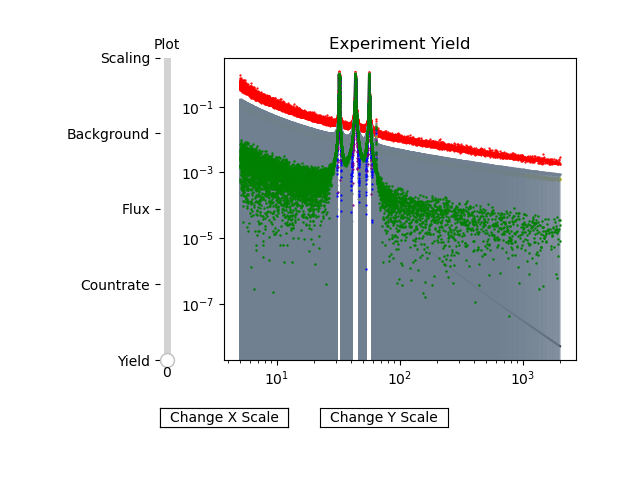

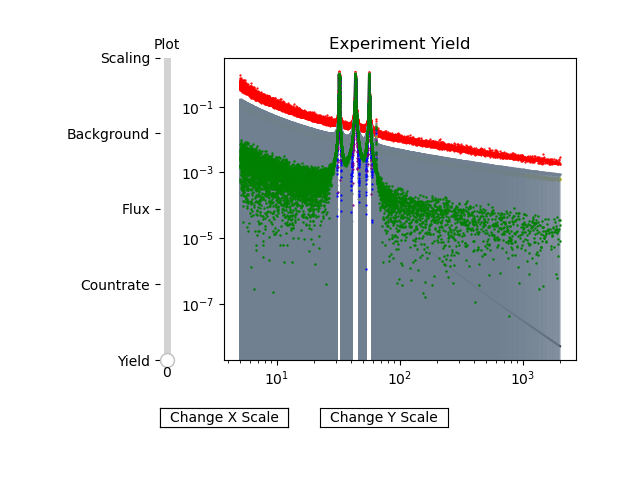

In [ ]:
#Plotting
#               plot label          Title                       Independent         Distributions               Colors                              Plot Type       x, y Scale          z Order
things_to_plot=[["Yield",           "Experiment Yield",         energy_domain,     [collection_max[0],
                                                                                    collection_upper[0],
                                                                                    collection_mean[0],
                                                                                    collection_lower[0],
                                                                                    collection_min[0],
                                                                                    exp_yield_theo],            ["r","y","g","blue","purple","k"],  [2,2,1,2,2,0],  ['log',  'log'],    [1,1,1,1,1,0]],
                ["Countrate",       "Experiment Countrate",     energy_domain,     [collection_max[1],
                                                                                    collection_upper[1],
                                                                                    collection_mean[1],
                                                                                    collection_lower[1],
                                                                                    collection_min[1],
                                                                                    exp_countrate_theo_2],        ["r","y","g","blue","purple","k"],  [2,2,1,2,2,0],  ['log',  'log'],    [1,1,1,1,1,0]],
                ["Flux",            "Test Flux",                energy_domain,     [collection_max[2],
                                                                                    collection_upper[2],
                                                                                    collection_mean[2],
                                                                                    collection_lower[2],
                                                                                    collection_min[2],
                                                                                    test_flux_theo],            ["r","y","g","blue","purple","k"],  [2,2,1,2,2,0],  ['log',  'log'],    [1,1,1,1,1,0]],
                ["Background",      "Experiment Background",    energy_domain,     [collection_max[3],
                                                                                    collection_upper[3],
                                                                                    collection_mean[3],
                                                                                    collection_lower[3],
                                                                                    collection_min[3],
                                                                                    exp_background_theo],       ["r","y","g","blue","purple","k"],  [2,2,1,2,2,0],  ['log',  'log'],    [1,1,1,1,1,0]],
                ["Scaling",         "Experiment Scaling",       energy_domain,     [collection_max[4],
                                                                                    collection_upper[4],
                                                                                    collection_mean[4],
                                                                                    collection_lower[4],
                                                                                    collection_min[4],
                                                                                    exp_scaling_theo],          ["r","y","g","blue","purple","k"],  [2,2,1,2,2,0],  ['log',  'log'],    [1,1,1,1,1,0]]
               ]
plotting(things_to_plot)

### Example functions

Below, the term 'reduction parameters' refers to the experimentally estimated values, i.e., $f_n$, background counts, flux.